<a href="https://colab.research.google.com/github/sayakpaul/A-Barebones-Image-Retrieval-System/blob/master/FaceNet_Like_Less_Stronger_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tf-nightly

In [ ]:
!pip install -q tensorflow-addons

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0-dev20200803


In [2]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
# Fix the random seeds
np.random.seed(666)
tf.random.set_seed(666)

In [75]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:5%]", "train[5%:10%]"],
    as_supervised=True
)

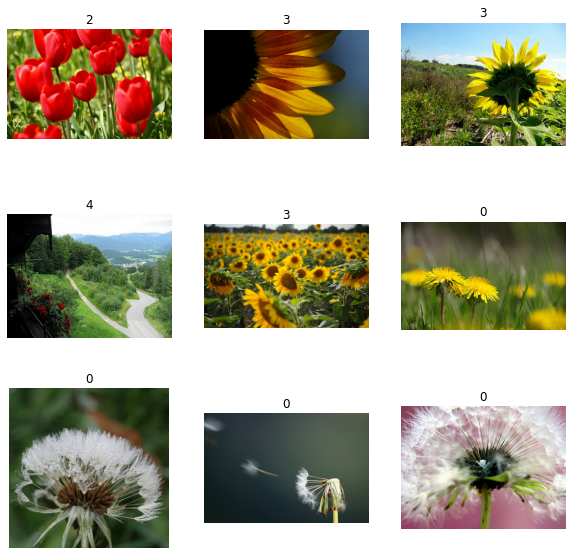

In [76]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

In [77]:
# Image resize
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [78]:
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)
# I did not use all the augmentation policies proposed in the above paper

def random_crop(image):
    image = tf.image.resize_with_crop_or_pad(image, 260, 260)
    image = tf.image.random_crop(image, size=[224, 224, 3])
    return image

@tf.function
def custom_augment(image, label):        
    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.4)
    
    # Random resize crops
    image =  random_apply(random_crop, image, p=0.3)

    # Randomly apply transformation (color distortions) with probability p.
    image = random_apply(color_jitter, image, p=0.4)
    image = random_apply(color_drop, image, p=0.6)
    
    # Make sure the pixel range is in within [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return (image, label)

@tf.function
def color_jitter(x, s=0.6):
    # one can also shuffle the order of following augmentations
    # each time they are applied.
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

@tf.function
def scale_img(image, label):
    image = tf.cast(image, tf.float32) / 255.
    return (image, label)

In [79]:
# Construct the batched dataset
batch_size = 64
AUTO = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(scale_img, num_parallel_calls=AUTO).\
    shuffle(1024).\
    map(custom_augment, num_parallel_calls=AUTO).\
    batch(batch_size).\
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.map(scale_img, num_parallel_calls=AUTO).\
    batch(batch_size).\
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

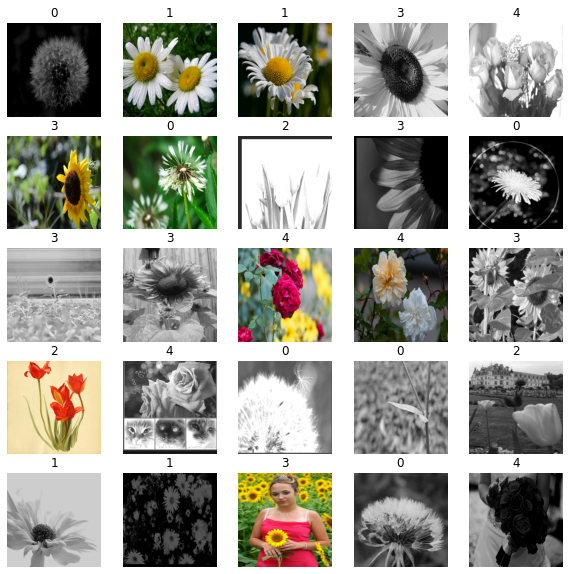

In [80]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis('off')

In [81]:
def embedding_model(embedding_dim, pretrained_model):
    inputs = Input(shape=(224, 224, 3))
    features = pretrained_model(inputs, training=False)
    
    x = GlobalAveragePooling2D()(features)
    x = Dense(2048, activation="relu")(x)
    x = Dense(embedding_dim)(x)
    outputs = Lambda(lambda a: tf.math.l2_normalize(a, axis=1))(x)
    
    model = Model(inputs, outputs)

    return model

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


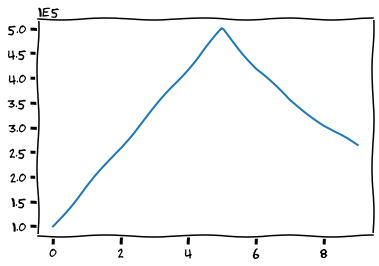

In [82]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(10)]
y = [lrfn(x) for x in rng]
with plt.xkcd():
    plt.plot(rng, [lrfn(x) for x in rng])

In [83]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, verbose=2, mode="auto",
    restore_best_weights=True
)

In [84]:
def plot_training(H, embedding_dim):
    with plt.xkcd():
        plt.plot(H.history["loss"], label="train_loss")
        plt.plot(H.history["val_loss"], label="val_loss")
        plt.title("Embedding dim: {}".format(embedding_dim))
        plt.legend(loc="lower left")
        plt.show()


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
      2/Unknown - 3s 1s/step - loss: 0.9971WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2407s vs `on_train_batch_end` time: 0.5653s). Check your callbacks.


      3/Unknown - 4s 1s/step - loss: 0.9969WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0078s vs `on_test_batch_end` time: 0.2257s). Check your callbacks.


3/3 [==============================] - 5s 2s/step - loss: 0.9968 - val_loss: 0.9955

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 0.9955 - val_loss: 0.9904

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.9897 - val_loss: 0.9843

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.9801 - val_loss: 0.9744

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.9578 - val_loss: 0.9631

Epoch 00006: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.9143 - val_loss: 0.9351

Epoch 00007: LearningRateSc

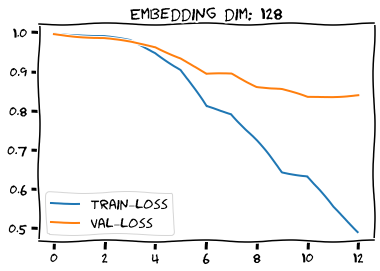

In [85]:
# VGG16 network Adam with 128-d embeddings
vgg_16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
vgg_16.trainable = True

model = embedding_model(128, vgg_16)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tfa.losses.TripletSemiHardLoss())

start = time.time()
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=50,
                    callbacks=[lr_callback, es])
end = time.time()-start
print("Model takes {} seconds to train".format(end))

plot_training(history, 128)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
      2/Unknown - 3s 2s/step - loss: 0.9981WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2320s vs `on_train_batch_end` time: 0.5649s). Check your callbacks.


      3/Unknown - 4s 1s/step - loss: 0.9978WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0090s vs `on_test_batch_end` time: 0.2243s). Check your callbacks.


3/3 [==============================] - 5s 2s/step - loss: 0.9977 - val_loss: 0.9953

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 0.9958 - val_loss: 0.9924

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.9914 - val_loss: 0.9870

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.9851 - val_loss: 0.9778

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.9631 - val_loss: 0.9601

Epoch 00006: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.9407 - val_loss: 0.9480

Epoch 00007: LearningRateSc

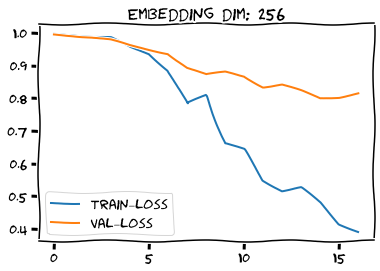

In [88]:
# VGG16 network Adam with 256-d embeddings
vgg_16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
vgg_16.trainable = True

model = embedding_model(256, vgg_16)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tfa.losses.TripletSemiHardLoss())

start = time.time()
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=50,
                    callbacks=[lr_callback, es])
end = time.time()-start
print("Model takes {} seconds to train".format(end))

plot_training(history, 256)

Epoch 1/50
      2/Unknown - 3s 1s/step - loss: 0.9966WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2362s vs `on_train_batch_end` time: 0.5689s). Check your callbacks.


      3/Unknown - 4s 1s/step - loss: 0.9964WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0081s vs `on_test_batch_end` time: 0.2250s). Check your callbacks.


3/3 [==============================] - 5s 2s/step - loss: 0.9963 - val_loss: 0.9930
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 0.9925 - val_loss: 0.9781
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.9852 - val_loss: 0.9886
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.9863 - val_loss: 0.9866
Epoch 00004: early stopping
Model takes 17.15695858001709 seconds to train


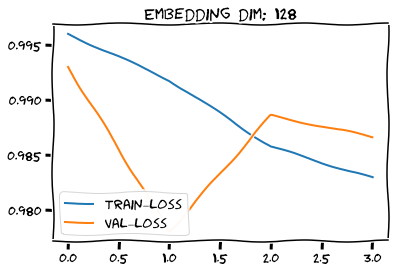

In [91]:
# VGG16 network Adam with 128-d embeddings + SGD + CosineDecay
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=1000)

vgg_16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
vgg_16.trainable = True

model = embedding_model(128, vgg_16)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn), loss=tfa.losses.TripletSemiHardLoss())

start = time.time()
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=50,
                    callbacks=[es])
end = time.time()-start
print("Model takes {} seconds to train".format(end))

plot_training(history, 128)

Epoch 1/50
      2/Unknown - 3s 1s/step - loss: 0.9972WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2456s vs `on_train_batch_end` time: 0.5719s). Check your callbacks.


      3/Unknown - 4s 1s/step - loss: 0.9971WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0088s vs `on_test_batch_end` time: 0.2283s). Check your callbacks.


3/3 [==============================] - 5s 2s/step - loss: 0.9970 - val_loss: 0.9943
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 0.9949 - val_loss: 0.9886
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.9886 - val_loss: 0.9839
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.9882 - val_loss: 0.9897
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.9828 - val_loss: 0.9759
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.9572 - val_loss: 0.9942
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.9950 - val_loss: 0.9832
Epoch 00007: early stopping
Model takes 30.0049467086792 seconds to train


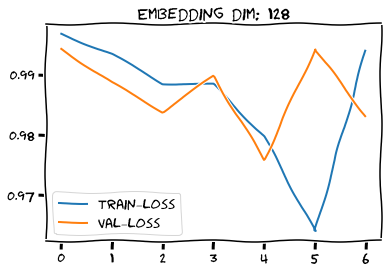

In [92]:
# VGG16 network Adam with 128-d embeddings + SGD + CosineDecayRestarts
lr_decayed_fn = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=0.1, first_decay_steps=1000)

vgg_16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
vgg_16.trainable = True

model = embedding_model(128, vgg_16)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn), loss=tfa.losses.TripletSemiHardLoss())

start = time.time()
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=50,
                    callbacks=[es])
end = time.time()-start
print("Model takes {} seconds to train".format(end))

plot_training(history, 128)

Epoch 1/50
      2/Unknown - 3s 2s/step - loss: 0.9960WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2393s vs `on_train_batch_end` time: 0.5639s). Check your callbacks.


      3/Unknown - 4s 1s/step - loss: 0.9955WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_test_batch_end` time: 0.2158s). Check your callbacks.


3/3 [==============================] - 5s 2s/step - loss: 0.9952 - val_loss: 0.9909
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 0.9930 - val_loss: 0.9820
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.9937 - val_loss: 0.9976
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.9971 - val_loss: 0.9945
Epoch 00004: early stopping
Model takes 17.652993202209473 seconds to train


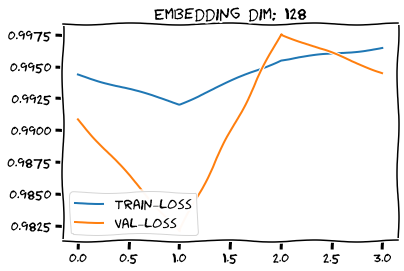

In [93]:
# VGG16 network Adam with 128-d embeddings + SGD + NoisyLinearCosineDecay
lr_decayed_fn = tf.keras.experimental.NoisyLinearCosineDecay(
    initial_learning_rate=0.1, decay_steps=1000)

vgg_16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
vgg_16.trainable = True

model = embedding_model(128, vgg_16)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn), loss=tfa.losses.TripletSemiHardLoss())

start = time.time()
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=50,
                    callbacks=[es])
end = time.time()-start
print("Model takes {} seconds to train".format(end))

plot_training(history, 128)

🤮